# **MobileNet**



**Import Necessary Libraries and Data**

In [ ]:
# To store and process in a dataframe
import pandas as pd
# Advanced ploting
import seaborn as sns
# For ploting graphs
import matplotlib.pyplot as plt
# For numerical analysis
import numpy as np
from numpy import argmax, array_equal
# Layers
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Dropout, Flatten, MaxPooling2D
# Train test split
from sklearn.model_selection import train_test_split
# Stop the training when there is no improvement in the loss for three consecutive epochs
from keras.callbacks import EarlyStopping
# Model performance metrics
from sklearn.metrics import classification_report
# Utility functions
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Sequential model
from tensorflow.keras.models import Sequential, Model
from imgaug import augmenters
from random import randint
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from PIL import Image
from tensorflow.keras.applications import MobileNet

In [ ]:
# Remove any file and Delete .kaggle directory
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
# Install Kaggle
!pip install -q kaggle

In [ ]:
# To upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaveeshahiruni","key":"e55502de6f913d6e141e149a78974607"}'}

In [ ]:
# To save this file into a directory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# To change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the food MNIST dataset from Kaggle
!kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset

 99% 811M/821M [00:15<00:00, 74.1MB/s]
100% 821M/821M [00:16<00:00, 53.7MB/s]


In [ ]:
# Extract the files in the zip file
!unzip -n 'fast-food-classification-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (10).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (100).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1000).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1001).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1002).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1003).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1004).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1005).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1006).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1007).jpeg  
  inflating: Fast Food Classification V2/T

In [ ]:
ROOT_PATH = '/content/Fast Food Classification V2'
training_path = f'{ROOT_PATH}/Train'
validation_path = f'{ROOT_PATH}/Test'
evaluation_path = f'{ROOT_PATH}/Valid'

In [ ]:
# Function to load and convert images to RGBA format
def load_and_convert_to_rgba(image_path):
    image = Image.open(image_path)
    if image.mode != "RGBA":
        image = image.convert("RGBA")
    return np.array(image)

# Example usage in the data generator:
def generator_with_rgba_conversion(generator):
    for batch_x, batch_y in generator:
        batch_x_rgba = [load_and_convert_to_rgba(image_path) for image_path in generator.filenames]
        yield (np.array(batch_x_rgba), batch_y)


**Data Preprocessing** : Before training the model, let's preprocess the data. This includes loading and augmenting the images.

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.2,
    fill_mode='nearest',
)


In [ ]:
# Validation and evaluation data
validation_datagen = ImageDataGenerator(rescale=1./255)
evaluation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define batch size
batch_size = 32

In [ ]:
# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(224, 224),    # Resize images
    batch_size=batch_size,
    class_mode='categorical'   # Use categorical labels for classification
)

# Modify the existing data generators to use the generator_with_rgba_conversion
train_generator_with_rgba = generator_with_rgba_conversion(train_generator)


Found 15000 images belonging to 10 classes.


In [ ]:
# Load and preprocess the validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator_with_rgba = generator_with_rgba_conversion(validation_generator)

Found 1500 images belonging to 10 classes.


In [ ]:
# Load and preprocess the evaluation data
evaluation_generator = evaluation_datagen.flow_from_directory(
    evaluation_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

evaluation_generator_with_rgba = generator_with_rgba_conversion(evaluation_generator)

Found 3500 images belonging to 10 classes.


In [ ]:
# Calculate class weights
from sklearn.utils import class_weight

# Class imbalance handling (compute class weights)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

In [ ]:
# Convert class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 10  # Number of epochs after which to drop learning rate
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)


In [ ]:
# Load the pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Build the own classification head
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adjust the learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define the number of training steps per epoch
num_train_samples = len(train_generator.filenames)
num_val_samples = len(validation_generator.filenames)
num_epochs = 20  # Adjust the number of epochs as needed

In [ ]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


**Training the model**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=num_val_samples // batch_size,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
126/468 [=======>......................] - ETA: 3:06 - loss: 1.3953 - accuracy: 0.5484

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


468/468 [==============================] - 280s 548ms/step - loss: 0.9457 - accuracy: 0.6977 - val_loss: 0.7170 - val_accuracy: 0.7772 - lr: 1.0000e-04
Epoch 2/20
468/468 [==============================] - 239s 512ms/step - loss: 0.5711 - accuracy: 0.8203 - val_loss: 0.8503 - val_accuracy: 0.7337 - lr: 1.0000e-04
Epoch 3/20
468/468 [==============================] - 242s 518ms/step - loss: 0.4581 - accuracy: 0.8569 - val_loss: 0.6367 - val_accuracy: 0.8071 - lr: 1.0000e-04
Epoch 4/20
468/468 [==============================] - 240s 513ms/step - loss: 0.4042 - accuracy: 0.8727 - val_loss: 0.7698 - val_accuracy: 0.7846 - lr: 1.0000e-04
Epoch 5/20
468/468 [==============================] - 241s 515ms/step - loss: 0.3557 - accuracy: 0.8864 - val_loss: 0.6291 - val_accuracy: 0.8105 - lr: 1.0000e-04
Epoch 6/20
468/468 [==============================] - 241s 516ms/step - loss: 0.3191 - accuracy: 0.8990 - val_loss: 0.7612 - val_accuracy: 0.7901 - lr: 1.0000e-04
Epoch 7/20
468/468 [=============

**Evaluate the model**

In [ ]:
#Test the model
evaluation_results = model.evaluate(evaluation_generator)
print("Evaluation loss:", evaluation_results[0])
print("Evaluation accuracy:", evaluation_results[1])

110/110 [==============================] - 8s 69ms/step - loss: 0.6047 - accuracy: 0.8263
Evaluation loss: 0.6047347784042358
Evaluation accuracy: 0.826285719871521


In [ ]:
predictions = model.predict(evaluation_generator)

110/110 [==============================] - 8s 66ms/step


**Visulaization of the predictions**

1/1 [==============================] - 0s 30ms/step


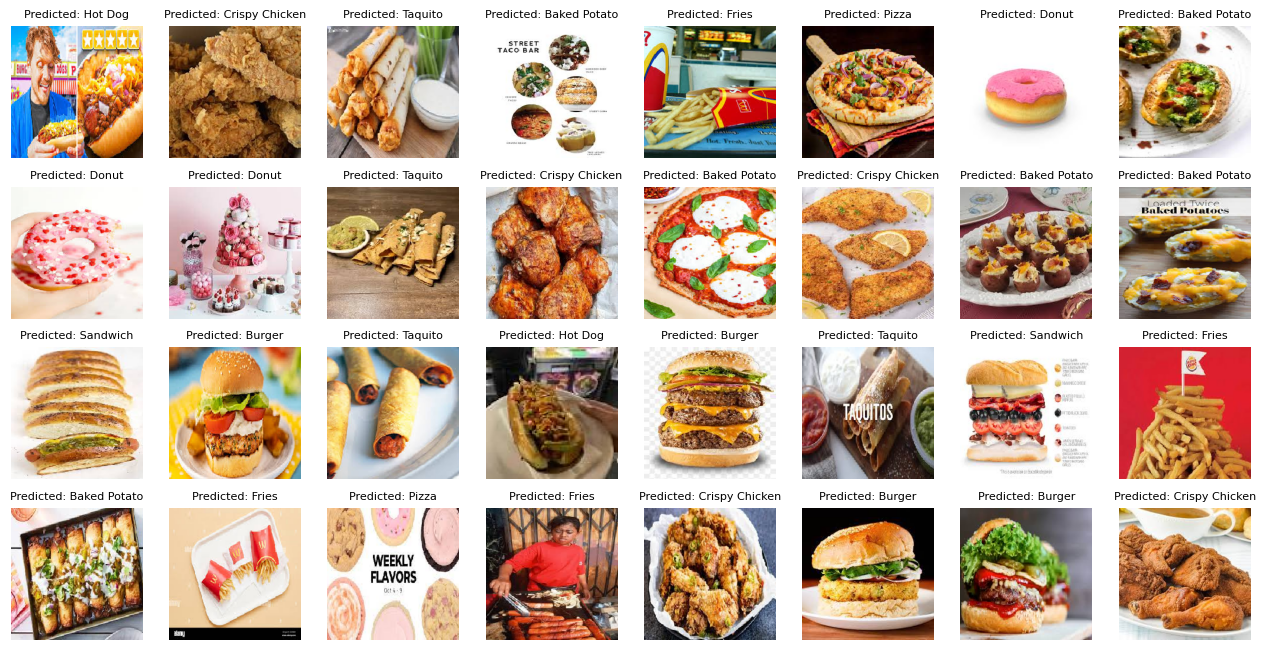

In [ ]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Get a batch of images and their true labels (if needed)
image_batch, true_labels_batch = next(evaluation_generator)

# Make predictions on the batch of images
predicted_labels_batch = model.predict(image_batch)

# Display the images along with their predicted labels
plt.figure(figsize=(16, 8))
for i in range(len(image_batch)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i])

    # Get the predicted label (index of the highest probability)
    predicted_label_index = np.argmax(predicted_labels_batch[i])

    # Map the predicted label index to the class label
    predicted_label = class_labels[predicted_label_index]

   # Display the predicted label with smaller text size
    plt.title(f'Predicted: {predicted_label}', fontsize=8)

    # Remove axis ticks and labels for a cleaner display
    plt.axis('off')

plt.show()

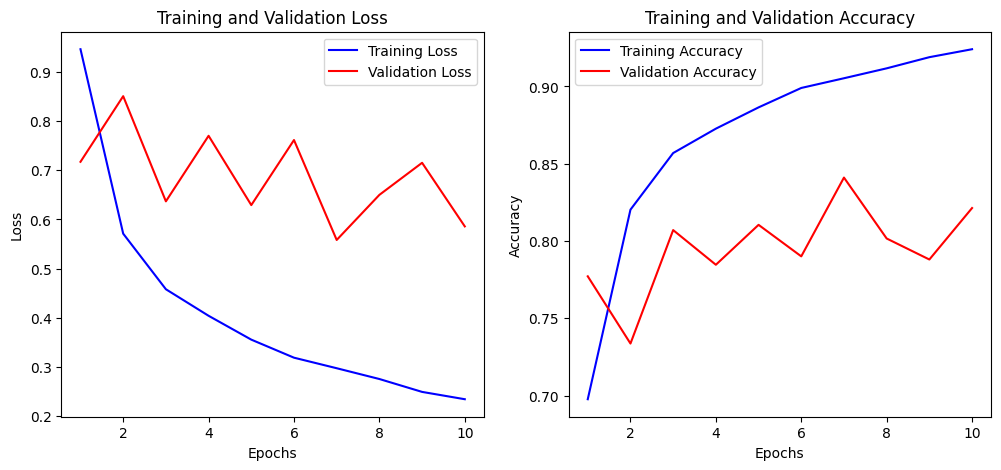

In [ ]:
# Access training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Confusion Matrix:** Visualize the confusion matrix to understand which classes are often confused with each other.

110/110 [==============================] - 12s 110ms/step


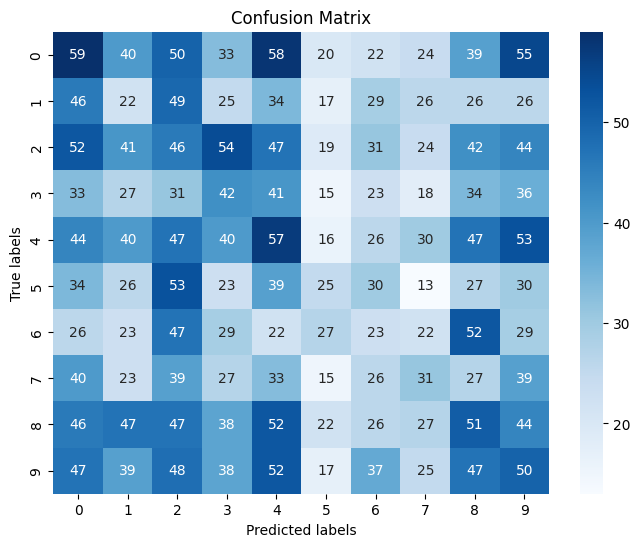

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the evaluation dataset
y_pred = model.predict(evaluation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = evaluation_generator.classes

# Create confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**ROC Curve and AUC:** Visualize the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC).
This is a classification problem that has 10 classe and the ROC analysis for each class is done individually (i.e., one-vs-all or one-vs-rest ROC curves).

110/110 [==============================] - 7s 67ms/step


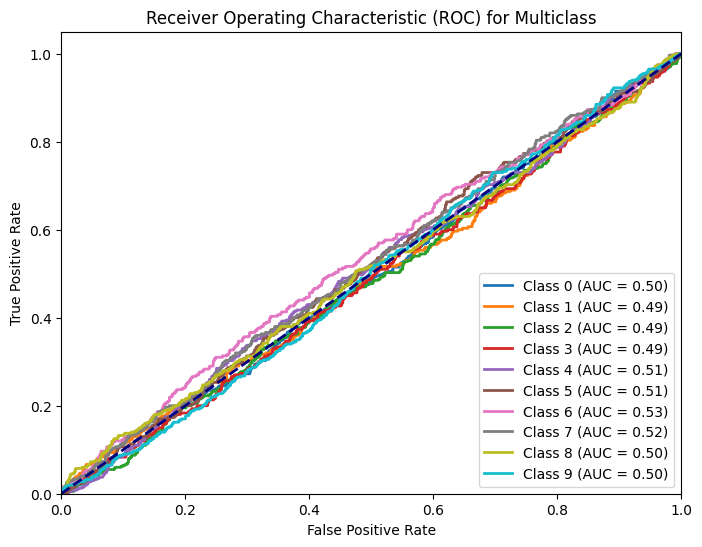

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming multiclass classification
n_classes = len(evaluation_generator.class_indices)

# Initialize empty lists for fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Generate predictions
predictions = model.predict(evaluation_generator)

# Get true labels
true_labels = evaluation_generator.classes

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multiclass')
plt.legend(loc='lower right')
plt.show()



# **Visualizations of the Dataset**

In [ ]:
import os

**Class Distribution Visualization** : Visualize the distribution of classes in your dataset using a bar chart. This helps to understand if the dataset is balanced or skewed towards certain classes.

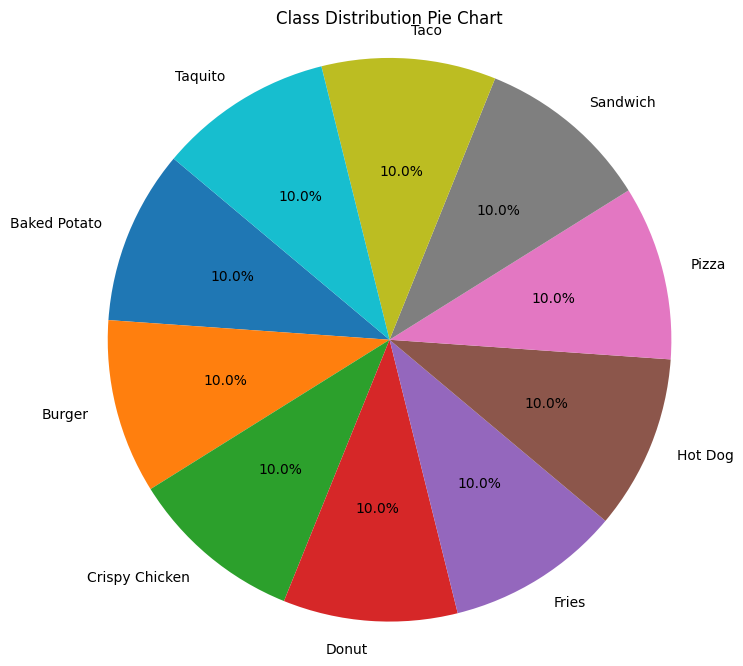

In [ ]:
# Count the number of samples per class in the training dataset
class_counts = train_generator.classes
class_names = list(train_generator.class_indices.keys())

# Calculate the number of samples in each class
class_sample_counts = [np.sum(class_counts == i) for i in range(len(class_names))]

# Create a pie chart to visualize the class distribution
plt.figure(figsize=(8, 8))
plt.pie(class_sample_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution Pie Chart')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

**Data Distribution Across Train, Validation, and Test Sets:**
Visualize the distribution of data across the training, validation, and test sets to ensure that they are balanced.

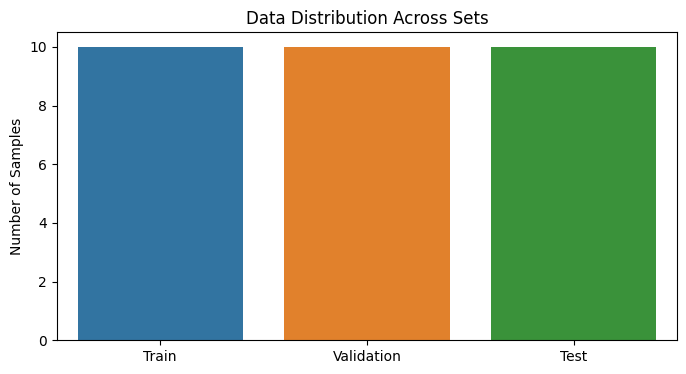

In [ ]:
# Get the number of samples in each set
train_count = len(os.listdir(training_path))
validation_count = len(os.listdir(validation_path))
evaluation_count = len(os.listdir(evaluation_path))

# Plot the distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=['Train', 'Validation', 'Test'], y=[train_count, validation_count, evaluation_count])
plt.title('Data Distribution Across Sets')
plt.ylabel('Number of Samples')
plt.show()

**Random Sample from a class**

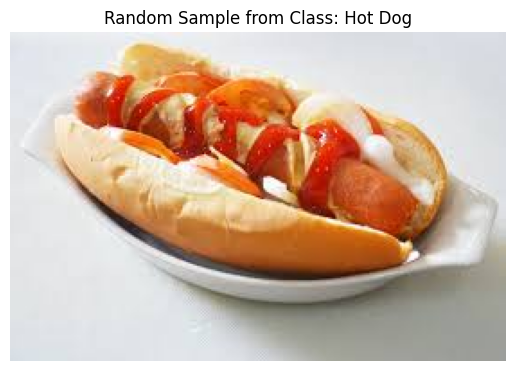

In [ ]:
import random
from PIL import Image

# Choose a random class
random_class = random.choice(class_names)

# Get a list of image file paths for that class
class_path = os.path.join(training_path, random_class)
image_files = os.listdir(class_path)

# Choose a random image from the class
random_image = random.choice(image_files)

# Load and display the random image
image_path = os.path.join(class_path, random_image)
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Random Sample from Class: {random_class}')
plt.axis('off')
plt.show()